# Tutorial of implementing Conditional GAN
mnist image에 대하여 Conditional Generative Adversarial Net을 학습하고, 학습된 Generator를 이용하여 원하는 숫자에 해당하는 mnist image를 Generate 해보는 예제, 기존의 Vanilla GAN과 거의 큰 차이가 존재하지 않는다. **차이는 단지 Generator와 Discriminator를 학습할 때, Generator에는 noise와 학습하고자하는 label 정보를 concatenate하여 학습하고, Discriminator에는 mnist image와 해당 mnist image의 label를 concatenate하여 입력으로 넣어서 학습한다.**
* Paper 
    * [Conditional Generative Adversarial Nets](https://arxiv.org/pdf/1411.1784.pdf)
* Reference
    * https://github.com/golbin/TensorFlow-Tutorials/blob/master/09%20-%20GAN/02%20-%20GAN2.py
* Illustartion : Generative Adversarial Net vs Conditional Generative Adversarial Net  
  ![Alt text](https://i.imgur.com/N4D1A9u.png)

### Setup 

In [1]:
import os, sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from tensorflow.examples.tutorials.mnist import input_data # load mnist dataset
mnist = input_data.read_data_sets(train_dir = './data/MNIST_data/', one_hot = True, reshape = True, seed = 777)
print(tf.__version__)

slim = tf.contrib.slim

c:\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting ./data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST_data/t10k-labels-idx1-ubyte.gz
1.6.0


In [2]:
class Generator:
    def __init__(self, input_dim, h_dims = [256]):
        self._input_dim = input_dim
        self._h_dims = h_dims
        
    def __call__(self, z, label):
        with tf.variable_scope('generator', reuse = tf.AUTO_REUSE):
            _net = tf.concat([z, label], axis = 1)
            
            with slim.arg_scope([slim.fully_connected], activation_fn = tf.nn.tanh,
                                weights_initializer = slim.xavier_initializer()):
            
                for layer, h_dim in enumerate(self._h_dims):
                    with tf.variable_scope('hidden_layer{}'.format(layer + 1)):
                        _net = slim.fully_connected(inputs = _net, num_outputs = h_dim)
                        
                with tf.variable_scope('output_layer'):
                    _output = slim.fully_connected(inputs = _net, num_outputs = self._input_dim,
                                               activation_fn = tf.nn.sigmoid)
        return _output

In [3]:
class Discriminator:
    def __init__(self, h_dims = [256]):
        self._h_dims = h_dims
        
    def __call__(self, inputs, label):
        with tf.variable_scope('discriminator', reuse = tf.AUTO_REUSE):
            _net = tf.concat([inputs, label], axis = 1)
            
            with slim.arg_scope([slim.fully_connected], activation_fn = tf.nn.tanh,
                                 weights_initializer = slim.xavier_initializer()):
                
                for layer, h_dim in enumerate(self._h_dims):
                    with tf.variable_scope('hidden_layer{}'.format(layer + 1)):
                        _net = slim.fully_connected(inputs = _net, num_outputs = h_dim)
                        
                with tf.variable_scope('output_layer'):
                    _score = slim.fully_connected(inputs = _net, num_outputs = 1,
                                                         activation_fn = None)
        return _score

In [4]:
class GAN:
    def __init__(self, z_dim, input_dim, n_label, g_h_dims, d_h_dims):
       
        self._z = tf.placeholder(dtype = tf.float32, shape = [None, z_dim])
        self._inputs = tf.placeholder(dtype = tf.float32, shape = [None, input_dim])
        self._label = tf.placeholder(dtype = tf.float32, shape = [None, n_label])
        
        self._generator = Generator(input_dim = input_dim, h_dims = g_h_dims)
        self._discriminator = Discriminator(h_dims = d_h_dims)

        self._fake = self._generator(z = self._z, label = self._label)
        
        d_logits_real = self._discriminator(inputs = self._inputs, label = self._label)
        d_logits_fake = self._discriminator(inputs = self._fake, label = self._label)
        
        d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real, labels = tf.ones_like(d_logits_real)))
        d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.zeros_like(d_logits_fake)))
                
        self._loss_D = d_loss_real + d_loss_fake
        self._loss_G = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.ones_like(d_logits_fake)))

    def generate(self, sess, z, label):
        feed_generate = {self._z : z, self._label : label}
        return sess.run(fetches = self._fake, feed_dict = feed_generate)

### Define Solver

In [5]:
class SolverForDiscriminator:
    def __init__(self, model, optimizer = tf.train.AdamOptimizer):
        self._model = model
        self._lr = tf.placeholder(dtype = tf.float32)
        self._optimizer = optimizer(learning_rate = self._lr)
        self._training_op = self._optimizer.minimize(loss = self._model._loss_D,
                                                         var_list = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                                                                      scope = 'discriminator'))
    def train(self, sess, z, inputs, label, lr):
        feed_train = {self._model._z : z, self._model._inputs : inputs, self._model._label : label, self._lr : lr}
        return sess.run(fetches = [self._training_op, self._model._loss_D], feed_dict = feed_train)

In [6]:
class SolverForGenerator:
    def __init__(self, model, optimizer = tf.train.AdamOptimizer):
        self._model = model
        self._lr = tf.placeholder(dtype = tf.float32)
        self._optimizer = optimizer(learning_rate = self._lr)
        
        self._training_op = self._optimizer.minimize(loss = self._model._loss_G,
                                                         var_list = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                                                                      scope = 'generator'))
    def train(self, sess, z, label, lr):
        feed_train = {self._model._z : z, self._model._label : label, self._lr : lr}
        return sess.run(fetches = [self._training_op, self._model._loss_G], feed_dict = feed_train)

### Training

In [7]:
gan = GAN(z_dim = 50, input_dim = 784, n_label = 10, g_h_dims = [100], d_h_dims = [100])

In [8]:
solver_for_g = SolverForGenerator(model = gan)
solver_for_d = SolverForDiscriminator(model = gan)

In [9]:
#hyper-parameter
epochs = 50
batch_size = 100
total_batch = int(mnist.train.num_examples / batch_size)

In [10]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [11]:
# training
loss_D_hist = []
loss_G_hist = []
sampled = []

for epoch in range(epochs):
    avg_loss_D, avg_loss_G = 0, 0
    
    for step in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size = batch_size)
        noise = np.random.randn(batch_size, 50)
        
        _, loss_D = solver_for_d.train(sess = sess, z = noise, inputs = batch_xs, label = batch_ys, lr = 1e-4)
        _, loss_G = solver_for_g.train(sess = sess, z = noise, label = batch_ys, lr = 1e-4)
        avg_loss_D += loss_D / total_batch 
        avg_loss_G += loss_G / total_batch
    
    if epoch % 10 == 0:
        print('epoch : {:3}. D loss : {:.3f}, G loss : {:.3f}'.format(epoch, avg_loss_D, avg_loss_G))
    
    loss_D_hist.append(avg_loss_D)
    loss_G_hist.append(avg_loss_G)
    
    # 10 epoch마다 0~9에 해당되는 mnist image를 생성
    if (epoch + 1) % 10 == 0:
        sampled.append(gan.generate(sess = sess, z = np.random.randn(10,50), label = np.identity(n = 10)))

epoch :   0. D loss : 0.108, G loss : 5.530
epoch :  10. D loss : 0.104, G loss : 3.473
epoch :  20. D loss : 0.136, G loss : 3.328
epoch :  30. D loss : 0.127, G loss : 3.786
epoch :  40. D loss : 0.113, G loss : 3.957


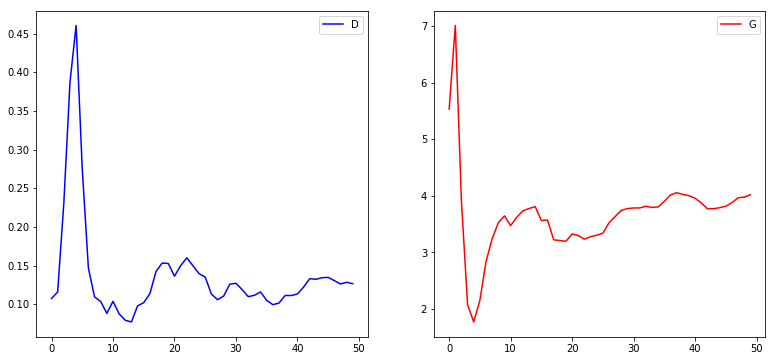

In [12]:
# visualize loss
fig = plt.figure(figsize = (15,6))
fig.subplots_adjust(right = .8)
fig.add_subplot(1,2,1)
plt.plot(loss_D_hist, label = 'D', c = 'b')
plt.legend()

fig.add_subplot(1,2,2)
plt.plot(loss_G_hist, label = 'G', c= 'r')
plt.legend()

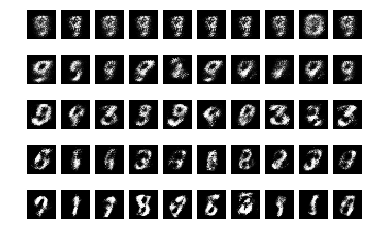

In [13]:
# epoch 8마다 Generator가 random noise + label 정보로 생성한 mnist images
for i in range(np.shape(sampled)[0]):
    for j in range(np.shape(sampled)[1]):
        plt.subplot2grid((np.shape(sampled)[0],np.shape(sampled)[1]),(i,j))
        plt.axis('off')
        plt.imshow(sampled[i][j].reshape(28,28), cmap = 'gray')